# Práctica de agrupamiento

## Autoría

* Nombre: Jorge Cabrera Rodríguez
* Email: alu0101351773@ull.edu.es
* Universidad: Universidad de La Laguna
* Máster: Ciberseguridad e Inteligencia de Datos
* Repositorio: [enlace](https://github.com/alu0101351773/ECBD_practicas.git)

## Introducción al dataset

En la base de datos _mallCustomers.csv_ se recogen los datos de 200 clientes de un centro comercial. El fichero consta de 5 variables, incluyendo el identificador de cada cliente (**CustomerID**).

Las variables en cuestión son las siguientes:

| Variable       | Descripción                                    | Valores       |
| -------------- | ---------------------------------------------- | ------------- |
| `Customer ID`    | identificador del cliente                      | Numérico      |
| `Gender`         | género del cliente                             | Male / Female |
| `Age`            | edad del cliente                               | Numérico      |
| `Annual.income`  | ingresos anuales del cliente                   | Numérico      |
| `Spending.score` | puntuación dada al cliente por el supermercado | Numérico      |

In [2]:
import pandas as pd

data = pd.read_csv(
    "../data/Base de datos - mallCustomers.csv"
)

data.head()

,CustomerID,Genre,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Ya que el ID de los usuarios es irrelevante a la hora de realizar el agrupamiento, se ha decidido eliminar esta columna del dataset.

In [3]:
if 'CustomerID' in data.columns:
    data.drop(columns = ['CustomerID'], inplace = True)
data.head()

,Genre,Age,Annual Income,Spending Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## Construcción de agrupamientos

### Agrupamiento con k-medias _(k-means)_

Lo primero que podemos hacer para visualizar los datos es representarlos mediante nubes de puntos, una por cada par de variables. De esta forma, podemos hacernos una idea de cómo se distribuyen los datos y si existen agrupamientos claros.

Para ello, vamos a graficar las siguientes variables:

* `Age` y `Annual.income`
* `Age` y `Spending.score`
* `Annual.income` y `Spending.score`

Text(970.81045751634, 0.5, 'Puntuación de gasto')

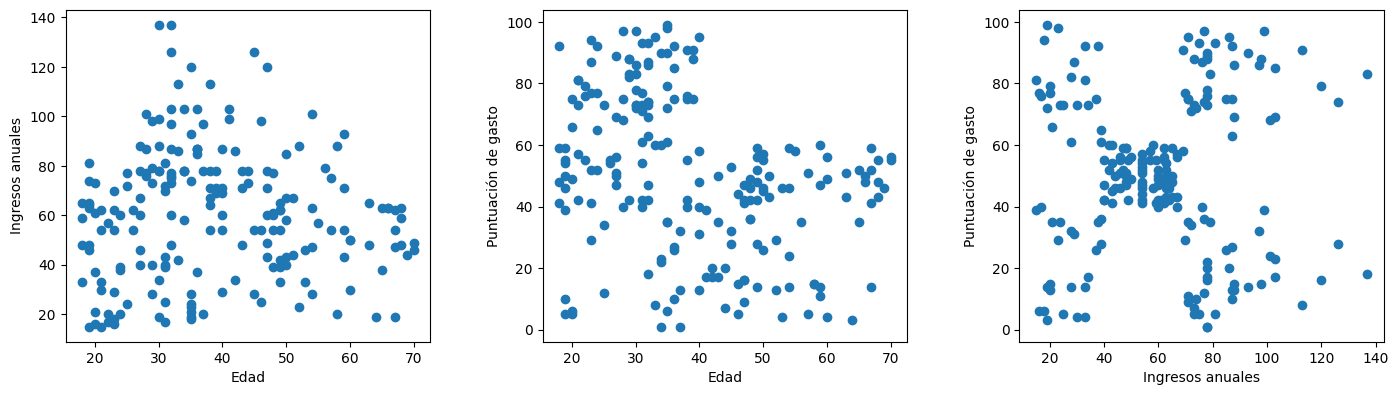

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
fig.tight_layout(pad = 5.0)

ax1.scatter(data['Age'], data['Annual Income'])
ax1.set_xlabel('Edad')
ax1.set_ylabel('Ingresos anuales')

ax2.scatter(data['Age'], data['Spending Score'])
ax2.set_xlabel('Edad')
ax2.set_ylabel('Puntuación de gasto')

ax3.scatter(data['Annual Income'], data['Spending Score'])
ax3.set_xlabel('Ingresos anuales')
ax3.set_ylabel('Puntuación de gasto')

Podemos observar una clara agrupación entre las variables `Spending Score` y `Annual Income`, por lo que podría ser interesante comenzar por ese par de variables para realizar el agrupamiento.

Comenzaremos con un _clustering_ de 5 grupos, para probar el funcionamiento del algoritmo de forma primitiva. Más adelante, calcularemos el número de grupos acorde al criterio del codo (_elbow method_).

Text(0.5, 1.0, 'Clustering con KMeans')

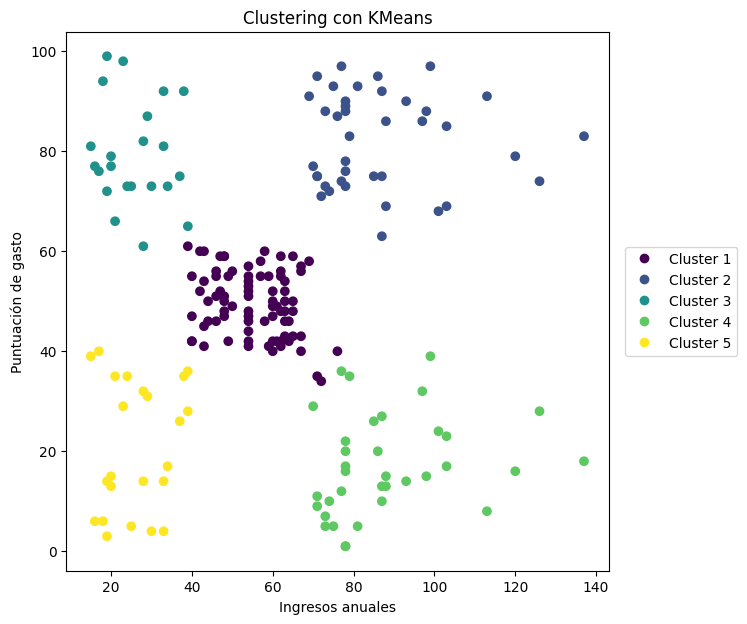

In [88]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state = 42, n_init = 'auto')
kmeans.fit(data[['Spending Score', 'Annual Income']])

labels = kmeans.labels_

fig, ax = plt.subplots(1, 1, figsize = (7, 7))

res = ax.scatter(
    data['Annual Income'],
    data['Spending Score'],
    c = labels
)
ax.set_xlabel('Ingresos anuales')
ax.set_ylabel('Puntuación de gasto')
ax.legend(
    handles = res.legend_elements()[0],
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
    loc = 'center right',
    bbox_to_anchor = (1.25, 0.5)
)
ax.set_title('Clustering con KMeans')

Podemos ver un agrupamiento con 5 grupos bastante bien distanciados y definidos. Ahora calcularemos el valor de información retenida de cada posible valor de _k_ para ver cuál es el número óptimo de grupos.

Para ello, graficaremos la información retenida, y para aquel valor de K tal que
el crecimiento a partir del mismo (`growth`) sea menor que un determinado
umbral (`threshold`), determinaremos ese punto como valor óptimo de _k_.

In [6]:
import numpy as np

def information_value(data: pd.DataFrame, cluster_number: int = 1) -> float:
    kmeans = KMeans(n_clusters = cluster_number, random_state = 42, n_init = 'auto')
    kmeans.fit(data)

    labels = kmeans.labels_
    total_variance = np.var(data, axis = 0).sum()
    cluster_centers = kmeans.cluster_centers_
    clustered_data = cluster_centers[labels]
    explained_variance = np.var(clustered_data, axis=0).sum()

    return explained_variance / total_variance    

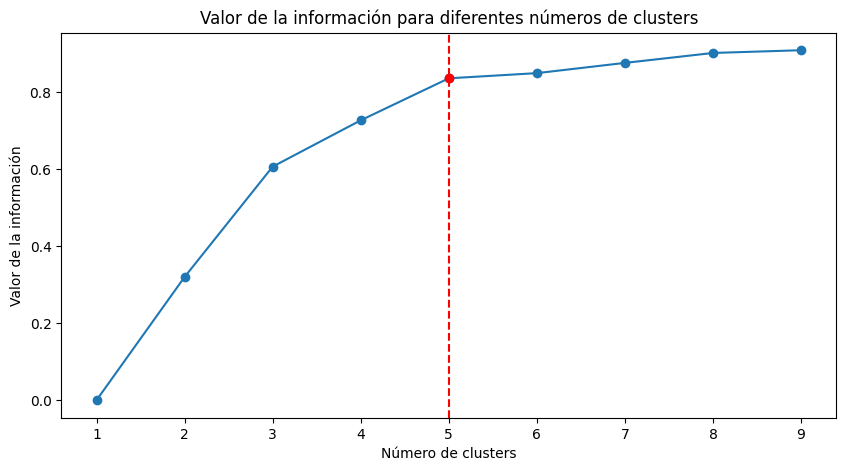

In [19]:
import numpy as np

k_values = np.arange(1, 10)
information_values = []

for i in k_values:
    information_values += [information_value(data[['Annual Income', 'Spending Score']], i)]

top_index = 0

growth_threshold = 0.02

for i, value in enumerate(information_values):
    growth = information_values[i + 1] - value
    if growth < growth_threshold:
        top_index = i
        break

fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.plot(k_values, information_values, marker = 'o')
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Valor de la información')
ax.set_title('Valor de la información para diferentes números de clusters')
ax.axvline(x = top_index + 1, color = 'red', linestyle = '--')

plt.plot(top_index + 1, information_values[top_index], marker = 'o', color = 'red')

Como podemos ver, el valor óptimo de _k_ es 5, que es el valor que habíamos elegido anteriormente. La información retenida para este valor de _k_ es la siguiente:

In [20]:
print(f'Información retenida para {top_index + 1} clusters: {information_values[top_index]:.2f}')

Información retenida para 5 clusters: 0.84


Si quisieramos calcular otra medida de rendimiento del agrupamiento, podríamos aplicar el método de la silueta, para comprobar la cohesión de los grupos. Para ello, calcularemos el valor de la silueta para cada punto, y graficaremos dichas siluetas.

Coeficiente promedio de silueta: 0.55


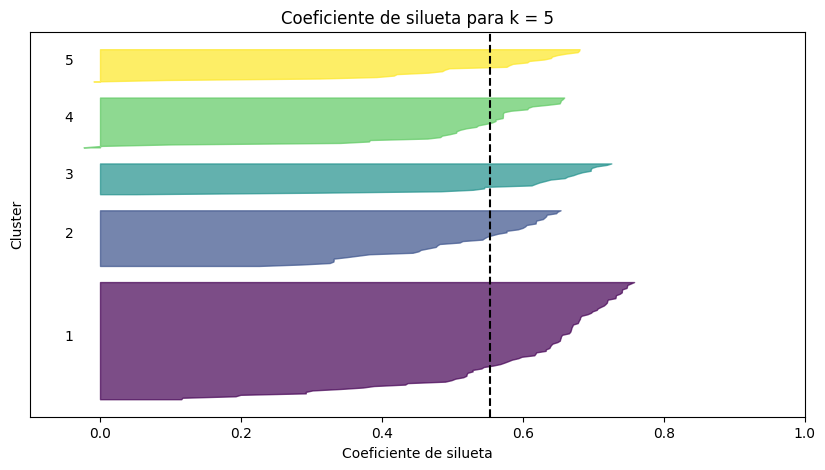

In [109]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.colors as mcolors

sil_avg = silhouette_score(data[['Annual Income', 'Spending Score']], labels)

sil_values = silhouette_samples(data[['Annual Income', 'Spending Score']], labels)

fig, ax = plt.subplots(1, 1, figsize = (10, 5))

y_lower = 10
for i in range(top_index + 1):
    ith_cluster_sil_values = sil_values[labels == i]
    ith_cluster_sil_values.sort()
    size_cluster_i = ith_cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster_i

    norm = mcolors.Normalize(vmin=0, vmax=top_index)
    color = plt.cm.viridis(norm(i))

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_sil_values,
        alpha = 0.7,
        color = color
    )

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))
    y_lower = y_upper + 10


ax.set_xlabel('Coeficiente de silueta')
ax.set_ylabel('Cluster')
ax.set_title('Coeficiente de silueta para k = 5')

ax.axvline(x = sil_avg, color = 'black', linestyle = '--')
ax.set_yticks([])
ax.set_xlim([-0.1, 1])

print(f'Coeficiente promedio de silueta: {sil_avg:.2f}')

El coeficiente medio de silueta de este agrupamiento es de 0.55, lo que indica que el agrupamiento es adecuado. Podemos ver que el _cluster_ 1 es el que parece tener una silueta más extrema: Cuenta con los puntos con silueta más alta (rozando el 0.8), pero también con los puntos con silueta más baja (rozando el 0.2).

El resto de _clusters_ mantienen un valor de silueta más regular, con valores entre 0.3 y 0.7 aproximadamente.

### Agrupamiento jerárquico

## Construcción de agrupamientos considerando el género

### Agrupamiento con k-medias _(k-means)_

### Agrupamiento jerárquico